# Машинное обучение 2020,  часть 2, семинар 6. Векторные представления на графах знаний

## Что такое граф знаний (knowledge graph)?

![](https://i.ibb.co/bLnP7Rv/Screenshot-from-2020-10-28-20-29-13.png)

**Open World Assumption**: из того, что между вершинами нет связи, ещё не значит, что её точно нет. Возможно мы о ней просто не знаем.

## Постановка задачи

Есть много разных вариантов. Мы будем предсказывать отсутствующие связи между объектами. А именно, выдавать тем бОльший скор для тройки, чем вероятнее, что такая связь есть.

Эту задачу можно рассматривать и как задачу бинарной классификации, и как задачу ранжирования.

На вход можно подавать некоторые фичи для вершин и фичи для ребра и строить предсказательную модель. Но подбирать руками очень неудобно...

На помощь приходят графовые эмбединги!

## Эмбединги

Чтобы обучать всё нужно придумать скоринговую функцию, которая будет давать тем больше скор тройке, чем выше вероятность, что она есть в графе. По этой функции методы и варьируются.

Например, метод, который мы будем сегодня рассматривать, TransE, основан на свойствах проекций:
$$
f_{TransE} = -||e_s + r_p - e_o||_n
$$

![](https://i.ibb.co/PmV4HNf/Screenshot-from-2020-10-28-20-42-36.png)

## А теперь к делу!

In [ ]:
!pip3 install tensorflow==1.15.2
!pip3 install folium==0.2.1
!pip3 install ampligraph

     |████████████████████████████████| 110.5MB 47kB/s 
     |████████████████████████████████| 512kB 48.6MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 3.8MB 44.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=46b43bec0ab839033da876003a23a13bbb09a1f70383523e8b0dc6a9c12b9373
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf
from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 1.3.2


## Датасет

Что вообще из себя представляет датасет, когда мы говорим о неких "векторных представлениях графов"? Граф он и представляет :)

А граф это ни что иное, как набор троек, каждая из котрых описывает некоторую связь. А именно, дуга между двумя вершинами :)

In [ ]:
from ampligraph.datasets import load_fb15k_237, load_wn18rr, load_yago3_10

Для начала загрузим некоторый стандартный граф знаний, использующийся в быту:

In [ ]:
import pandas as pd

URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
dataset = pd.read_csv(URL, header=None)
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(5)

,subject,predicate,object
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1,digital equipment corporation,/business/business_operation/industry,computer hardware
2,/m/0drtv8,/award/award_ceremony/awards_presented./award/...,laurence mark
3,the departed,/award/award_winning_work/awards_won./award/aw...,leonardo dicaprio
4,marilyn manson,/people/person/profession,actor


In [ ]:
print('Total triples in the KG:', dataset.shape)

Total triples in the KG: (310079, 3)


![KG](https://user-images.githubusercontent.com/39597669/90747195-9fc44c80-e2c8-11ea-9f70-097993581bac.png) 

## Разделение на train и test

А что мы, собственно, хотим предсказать?..

Обычно ставится задача по известным связям предсказать возможные неизвестные. Например, если мы имеем социальную сеть, хочется порекомендовать кому-либо новых друзей!

Поэтому разделение на обучающую и тестовую выборку будет именно этих троек, которые даны нам в качестве данных.

Но есть и ещё один момент. Нельзя предсказывать что-то для объектов, которые вы никогда не видели. Поэтому в обучающей выборке все объекты должны присутствовать хотя бы по одному разу:

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen

test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)

print('Total triples:', dataset.shape)
print('Size of train:', X_train.shape)
print('Size of valid:', X_valid.shape)
print('Size of test:', X_test.shape)

Total triples: (310079, 3)
Size of train: (308579, 3)
Size of valid: (500, 3)
Size of test: (1000, 3)


## Обучение модели

Библиотека ampligraph предоставляет множество различных алгоритмов. Например, алгоритм TransE:

In [ ]:
from ampligraph.latent_features import TransE

model = TransE(k=150,                                                             # embedding size
               epochs=100,                                                        # Num of epochs
               batches_count= 10,                                                 # Number of batches 
               eta=1,                                                             # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)

model.fit(X_train)

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE-small.pkl')

Average Loss:   0.013713: 100%|██████████| 100/100 [02:03<00:00,  1.24s/epoch]


In [ ]:
model = restore_model('TransE-small.pkl')

## Метрики качества

Допустим, мы обучили модель. Давайте попробуем вытащить из неё какую-нибудь полезную информацию :) Например, воспользуемся методом predict, который выдаёт некоторый скор того, что такая тройка может присутствовать в графе:

In [ ]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score:
 [-8.20327]


О чём нам может рассказать этот скор? Да в целом ни о чём не может. Потому что на самом деле мы обучаемся для задачи ранжирования, т.е. абсолютная величина не важна, важен только порядок.

In [ ]:
import numpy as np
list_of_actors = ['salma hayek', 'carrie fisher', 'natalie portman',  'kristen bell',
                  'mark hamill', 'neil patrick harris', 'harrison ford' ]

# stack it horizontally to create s, p, o
hypothesis = np.column_stack([list_of_actors, 
                              ['/film/actor/film./film/performance/film'] * len(list_of_actors),
                              ['star wars'] * len(list_of_actors),
                             ])

# score the hypothesis
triple_scores = model.predict(hypothesis)

# append the scores column
scored_hypothesis = np.column_stack([hypothesis, triple_scores])
# sort by score in descending order
scored_hypothesis = scored_hypothesis[np.argsort(scored_hypothesis[:, 3])]
scored_hypothesis

array([['harrison ford', '/film/actor/film./film/performance/film',
        'star wars', '-8.20327'],
       ['carrie fisher', '/film/actor/film./film/performance/film',
        'star wars', '-8.353799'],
       ['natalie portman', '/film/actor/film./film/performance/film',
        'star wars', '-8.632348'],
       ['mark hamill', '/film/actor/film./film/performance/film',
        'star wars', '-8.898188'],
       ['salma hayek', '/film/actor/film./film/performance/film',
        'star wars', '-9.097838'],
       ['neil patrick harris', '/film/actor/film./film/performance/film',
        'star wars', '-9.143508'],
       ['kristen bell', '/film/actor/film./film/performance/film',
        'star wars', '-9.694317']], dtype='<U39')

Есть ещё одна интересная метрика. Как раз можно оценить то, насколько мы хорошо занимаемся ранжированием. А именно, конкретная тройка должна оцениваться уж точно выше, чем её "испорченые" версии, в которых объект либо субъект заменяется на случайных.

Давайте разберёмся как её считать на примере!

Для начала посмотрим, а сколько у нас вообще есть уникальных сущностей (вершин графа):

In [ ]:
print('The number of unique entities:', len(model.ent_to_idx))

The number of unique entities: 14184


Теперь сгенерируем так называемые subject corruptions:

In [ ]:
subj_corr =  np.column_stack([list(model.ent_to_idx.keys()),
                [test_triple[1]] * len(model.ent_to_idx), 
                [test_triple[2]] * len(model.ent_to_idx)])

print('Subject corruptions:\n', subj_corr)
print('\nSize of subject corruptions:\n', subj_corr.shape)

Subject corruptions:
 [['/m/011xg5' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yd2' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yxg' '/film/actor/film./film/performance/film' 'star wars']
 ...
 ['zoology' '/film/actor/film./film/performance/film' 'star wars']
 ['zurich' '/film/actor/film./film/performance/film' 'star wars']
 ['zz top' '/film/actor/film./film/performance/film' 'star wars']]

Size of subject corruptions:
 (14184, 3)


Посчитаем теперь скоры для этих испорченных троек:

In [ ]:
sub_corr_score = model.predict(subj_corr)

Теперь нас интересует то, на каком месте в ранжировании будет стоять исходная тройка:

In [ ]:
sub_rank_worst = np.sum(np.greater_equal(sub_corr_score, triple_score[0])) + 1

print('Assigning the worst rank (to break ties):', sub_rank_worst)

Assigning the worst rank (to break ties): 1657


Аналогично для объекта:

In [ ]:
obj_corr =  np.column_stack([
                [test_triple[0]] * len(model.ent_to_idx),
                [test_triple[1]] * len(model.ent_to_idx), 
                     list(model.ent_to_idx.keys())])


print('Object corruptions:\n', obj_corr)
print('\nSize of object corruptions:\n', obj_corr.shape)

# f. Compute the score of the object corruptions
obj_corr_score = model.predict(obj_corr)

# g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank
obj_rank_worst = np.sum(np.less_equal(triple_score[0], obj_corr_score)) + 1
print('Assigning the worst rank (to break ties):', obj_rank_worst)

Object corruptions:
 [['harrison ford' '/film/actor/film./film/performance/film' '/m/011xg5']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yd2']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yxg']
 ...
 ['harrison ford' '/film/actor/film./film/performance/film' 'zoology']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zurich']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zz top']]

Size of object corruptions:
 (14184, 3)
Assigning the worst rank (to break ties): 842


В итоге наша метрика -- это два числа. Чем они меньше, тем лучше!

In [ ]:
print('Subject corruption rank:', sub_rank_worst)
print('Object corruption rank:', obj_rank_worst)

Subject corruption rank: 1657
Object corruption rank: 842


Но всё это можно посчитать и встроенными методами:

In [ ]:
from ampligraph.evaluation import evaluate_performance 

ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             ranking_strategy='worst')

print('\nRanks:', ranks)

100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


Ranks: [[1657  842]]


В приведённой выше схеме есть одна небольшая проблема: true positives.

А именно, не все тройки на самом деле являются corruptions. Ведь некоторые из них могли присутствовать в обучающей выборке (а значит ещё и скоры получают высокие). Для того, чтобы всё учитывалось более корректно, нужно из corruptions выкинуть те тройки, которые на самом деле есть в выборке (обучающей, тестовой либо валидационной).

**Задача 1 (0.5 балла)**. Модифицируйте самописный код вычисления метрики, чтобы учесть false positives. Сравните вашу реализацию с тем, что выдаёт evaluate_performance, если ему передать подходящий параметр filter_triplets.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
unique_triples = set()
for row in dataset.to_numpy():
  unique_triples.add("".join(row))

In [ ]:
subj_corr_filtr = []

for triple in tqdm(subj_corr):
  if "".join(triple) not in unique_triples:
    subj_corr_filtr.append(triple)

subj_corr_filtr = np.array(subj_corr_filtr)
subj_corr_filtr.shape

(14168, 3)

In [ ]:
obj_corr_filtr = []

for triple in tqdm(obj_corr):
  if "".join(triple) not in unique_triples:
    obj_corr_filtr.append(triple)

obj_corr_filtr = np.array(obj_corr_filtr)
obj_corr_filtr.shape

(14166, 3)

In [ ]:
sub_corr_score = model.predict(subj_corr_filtr)
sub_rank_worst = np.sum(np.less_equal(triple_score[0], sub_corr_score)) + 1
print('Subject corruption rank:', sub_rank_worst)

obj_corr_score = model.predict(obj_corr_filtr)
obj_rank_worst = np.sum(np.less_equal(triple_score[0], obj_corr_score)) + 1
print('Object corruption rank:', obj_rank_worst)

Subject corruption rank: 1646
Object corruption rank: 832


In [62]:
X_filter = np.concatenate([X_train, X_valid, X_test], 0)
ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             ranking_strategy='worst',
                             filter_triples=X_filter)





100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


In [63]:
ranks

array([[1646,  832]], dtype=int32)

Окей, но это всё метрики для одного объекта. А у нас же тут целый тест-сет!

Давайте создадим небольшенький тест-сет для примера и посчитаем на нём метрику рангов:

In [64]:
X_test_small = np.array(
                [['doctorate',
                    '/education/educational_degree/people_with_this_degree./education/education/major_field_of_study',
                    'computer engineering'],

                ['star wars',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['harry potter and the chamber of secrets',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['star wars', '/film/film/language', 'english language'],
                ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']])


X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test_small, 
                             model=model, 
                             filter_triples=X_filter)
print(ranks)





  0%|          | 0/5 [00:00<?, ?it/s]



100%|██████████| 5/5 [00:00<00:00, 28.31it/s]


[[   6    7]
 [   1    1]
 [ 106    1]
 [   1    2]
 [1646  832]]


Эти числа можно аггрегировать несколькими разными способами:

Mean Rank (MR):
![mr formula](https://user-images.githubusercontent.com/281477/90627586-105d6180-e214-11ea-84d4-c5d3e4b089f4.png)

In [65]:
from ampligraph.evaluation import mr_score
print('MR :', mr_score(ranks))

MR : 260.3


Mean reciprocal rank (MRR)

![mrr formula](https://user-images.githubusercontent.com/281477/90627604-12272500-e214-11ea-9777-5d30b23f0d6f.png)

In [66]:
from ampligraph.evaluation import mrr_score
print('MRR :', mrr_score(ranks))

MRR : 0.48207672282792224


**hits@n** - процент попаданий в топ-$N$
![hits formula](https://user-images.githubusercontent.com/281477/90627565-09365380-e214-11ea-81c8-292a3de016d0.png)

In [67]:
from ampligraph.evaluation import hits_at_n_score
print('hits@1 :', hits_at_n_score(ranks, 1))
print('hits@10 :', hits_at_n_score(ranks, 10))

hits@1 : 0.4
hits@10 : 0.7


**Задача 2 (0.5 балла)**. Пусть наша модель показала $MRR$ близкий к 0, скажем, 0.01. Хорошая ли это модель? Если нет, то почему и на что ещё следует обратить внимание, чтобы понять, хорошая или нет?

***Ответ***
Так как мы выяснили, что значения близкие к 1 - это хорошо, то значение близкие к 0 - это не оч.

Первое предположение - модель недообучена.

Второе - возможно у нас набор данных такой, что много совпадаюших по смыслу троек и корупция объектов не будет вносить какую серьезную вариативность.

In [68]:
def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))

Итак, мы научились считать качество. Но что, если у нас в графе миллионы сущностей (как в реальной жизни)?

Во-первых, мы можем посчитать метрику для какого-то конкретного свойства между объектами:

In [70]:
X_test_movie_languages = X_test[X_test[:, 1] == '/film/film/language']
X_test_movie_languages

array([['tropic thunder', '/film/film/language', 'standard chinese'],
       ['burt munro', '/film/film/language', 'english language'],
       ['shining through', '/film/film/language', 'english language'],
       ['/m/02v63m', '/film/film/language', 'english language'],
       ['topaz', '/film/film/language', 'french'],
       ['the tourist', '/film/film/language', 'russian language'],
       ['gran torino', '/film/film/language', 'english language'],
       ['bedazzled', '/film/film/language', 'spanish language'],
       ['casper', '/film/film/language', 'english language'],
       ['the usual suspects', '/film/film/language', 'english language']],
      dtype=object)

In [71]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter)

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)





  0%|          | 0/10 [00:00<?, ?it/s]



 20%|██        | 2/10 [00:00<00:00, 19.22it/s]



 60%|██████    | 6/10 [00:00<00:00, 22.02it/s]



100%|██████████| 10/10 [00:00<00:00, 30.43it/s]


Mean Rank: 799.5
Mean Reciprocal Rank: 0.09254835131355736
Hits@1: 0.05
Hits@10: 0.3
Hits@100: 0.6

Size of test set: (10, 3)
Size of ranks: (10, 2)


Во-вторых, можно использовать только одну из сторон (субъект/объект) для генерации испорченных троек:

In [72]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)





  0%|          | 0/10 [00:00<?, ?it/s]



100%|██████████| 10/10 [00:00<00:00, 51.04it/s]


Mean Rank: 16.2
Mean Reciprocal Rank: 0.1730899304477297
Hits@1: 0.1
Hits@10: 0.6
Hits@100: 1.0

Size of test set: (10, 3)
Size of ranks: (10,)


В-третьих, можно использовать не все возможные сущности для генерации испорченных троек, а только из какого-то набора:

In [73]:
print('The number of corruptions generated per triple is:', len(model.ent_to_idx))

The number of corruptions generated per triple is: 14184


In [74]:
unique_languages = set(X_train[X_train[:, 1] == '/film/film/language'][:, 2])

print('Number of languages in KG:', len(unique_languages))
print('\n', unique_languages)

Number of languages in KG: 61

 {'bulgarian language', 'england', 'welsh language', 'cantonese', 'thai language', 'russian language', 'khmer language', 'italian language', 'yiddish language', 'chinese language', 'serbo-croatian language', 'american english', 'irish', 'swedish language', 'silent film', 'hebrew language', 'punjabi language', 'urdu language', 'czech language', 'hindi language', 'greek language', 'bengali language', 'tagalog language', 'croatian language', 'indonesian language', 'german food', 'albanian language', 'malay language', 'sinhala language', 'persian language', 'dutch language', 'serbian language', 'gujarati language', 'filipino language', 'italian food', 'spanish language', 'english language', 'yue chinese', 'arabic language', 'afrikaans language', 'korean language', 'tamil language', 'swahili language', 'japanese language', 'vietnamese language', 'germany', 'norwegian language', 'hungarian language', 'portuguese language', 'latin language', 'french', 'romanian 

In [75]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

/usr/local/lib/python3.6/dist-packages/ampligraph/latent_features/models/EmbeddingModel.py:1140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':




  0%|          | 0/10 [00:00<?, ?it/s]



100%|██████████| 10/10 [00:00<00:00, 72.73it/s]


Mean Rank: 12.5
Mean Reciprocal Rank: 0.17841450216450216
Hits@1: 0.1
Hits@10: 0.6
Hits@100: 1.0


## Применение модели

А теперь давайте попробуем применить модель для ещё чего-нибудь полезного!

Например, ради интереса попробуем сгенерировать новые факты:

In [76]:
from ampligraph.discovery import discover_facts

triples, ranks = discover_facts(dataset.values, 
                                model, 
                                top_n=500, 
                                max_candidates=500, 
                                strategy='cluster_triangles', 
                                target_rel='/people/person/profession', 
                                seed=42)

for triple, rank in zip(triples, ranks):
    print('Rank: {} \t {} '.format(rank, triple))


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.






  0%|          | 0/500 [00:00<?, ?it/s]



  0%|          | 2/500 [00:00<00:30, 16.13it/s]



  1%|          | 6/500 [00:00<00:25, 19.01it/s]



  2%|▏         | 10/500 [00:00<00:22, 21.39it/s]



  3%|▎         | 14/500 [00:00<00:20, 23.74it/s]



  4%|▎         | 18/500 [00:00<00:18, 25.68it/s]



  4%|▍         | 21/500 [00:00<00:18, 26.30it/s]



  5%|▌         | 25/500 [00:00<00:17, 27.65it/s]



  6%|▌         | 29/500 [00:00<00:16, 29.02it/s]



  7%|▋         | 33/500 [00:01<00:15, 29.99it/s]



  7%|▋         | 37/500 [00:01<00:14, 31.00it/s]



  8%|▊         | 41/500 [00:01<00:14, 31.53it/s]



  9%|▉         | 45/500 [00:01<00:14, 31.40it/s]



 10%|▉         | 49/500 [00:01<00:14, 31.60it/s]



 11%|█         | 53/500 [00:01<00:13, 32.04it/s]



 11%|█▏        | 57/500 [00:01<00:13, 31.94it/s]



 12%|█▏        | 61/500 [00:01<00:13, 32.25it/s]



 13%|█▎        | 65/500 [00:02<00:13, 32.20it/s]



 14%|█▍        | 69/500 [00:02<00:13, 31.93it/s]



 15%|█▍        | 73

Rank: 21.0 	 ['bob clampett' '/people/person/profession' 'actor'] 
Rank: 371.5 	 ['bob boyle' '/people/person/profession' 'actor'] 


**Задача 3 (2 балла)**. Давайте заиспользуем эмбединги, которые получились, для кластеризации сущностей. А именно:
* возьмите все сущности, которые есть в датасете
* с получите их эмбединги из модели
* кластеризуйте полученные эмбединги, подобрав оптимальное значение кластеров
* визуализируйте полученные кластеры в 2D, воспользовавшись PCA
* проанализируйте результаты: получилось ли что-то адекватное?

In [79]:
subjects = np.array(list(model.ent_to_idx.keys()))
print(subjects.shape)
print(subjects[:10])

(14184,)
['/m/011xg5' '/m/011yd2' '/m/011yxg' '/m/013b2h' '/m/013nky' '/m/0148nj'
 '/m/014knw' '/m/014l7h' '/m/014nq4' '/m/014v6f']


In [81]:
embeddings = model.get_embeddings(entities=subjects)
print(embeddings.shape)
print(embeddings[:10])

(14184, 150)
[[ 0.00361559  0.00150256  0.01343476 ...  0.03647874 -0.01158627
   0.04734979]
 [ 0.03388735  0.02916347  0.03319202 ... -0.00011223  0.01224082
   0.01957875]
 [-0.01732488 -0.01291815  0.02487562 ...  0.06388081 -0.04569159
   0.01405792]
 ...
 [-0.03590339  0.05635695  0.0207604  ... -0.0365693   0.01509704
  -0.04178714]
 [ 0.05182725  0.0693877  -0.00684481 ...  0.0520452   0.0110968
   0.05201003]
 [ 0.00859681 -0.01207149  0.0283604  ... -0.06395673 -0.01235593
  -0.05826146]]


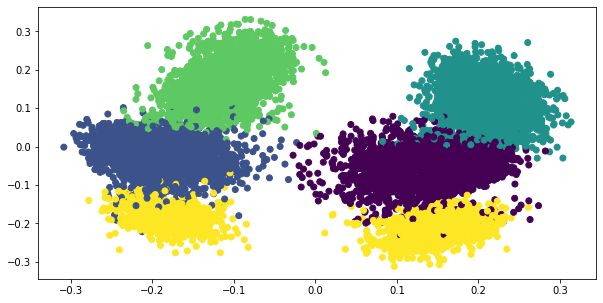

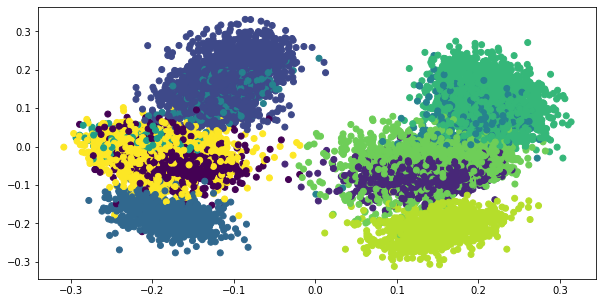

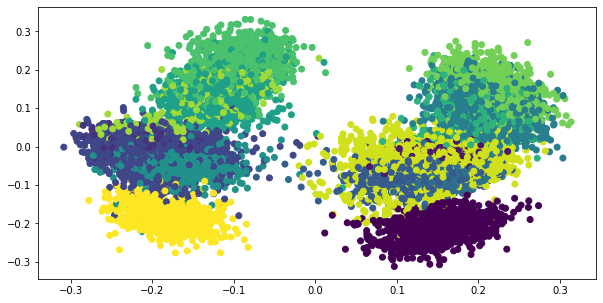

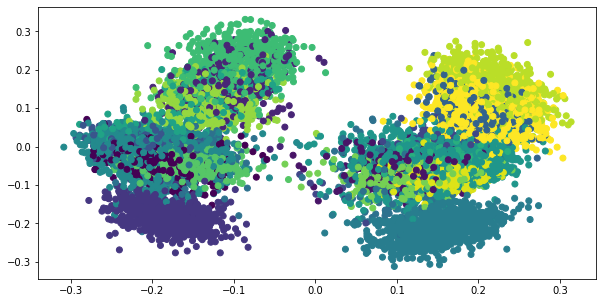

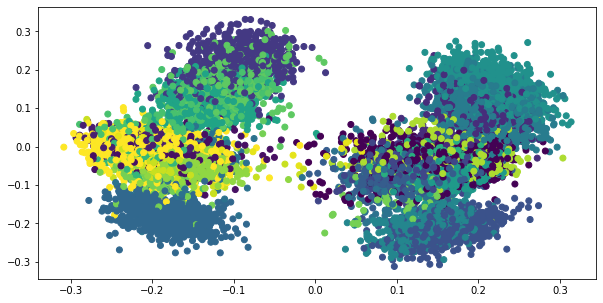

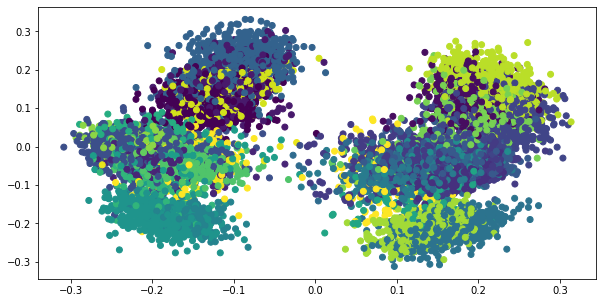

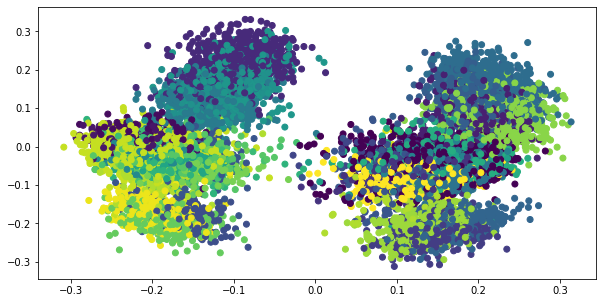

In [82]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

for k in range(5, 36, 5):
  labels = KMeans(n_clusters=k, random_state=0).fit_predict(embeddings)
  pca_emb = PCA(n_components=2).fit_transform(embeddings)

  plt.figure(figsize=(10, 5))
  plt.scatter(pca_emb[:, 0], pca_emb[:, 1], c=labels)
  plt.show()

Посмотрим, что получилось для 5, 15, 25 и 35 кластеров.

In [87]:
for cluster in range(6):
    print(f'Cluster: {cluster} : {subjects[labels == cluster][:15]}')

Cluster: 0 : ['/m/014l7h' '/m/018vbf' '/m/01cpp0' '/m/01fjfv' '/m/01gtc0' '/m/01pqx6'
 '/m/01qn7n' '/m/01tgwv' '/m/022tfp' '/m/024tkd' '/m/0257yf' '/m/025tn92'
 '/m/025ygqm' '/m/026k4d' '/m/027b9ly']
Cluster: 1 : ['/m/017_hq' 'ac' 'aerosmith' 'afi' 'black sabbath'
 'blood sweat and tears' 'bon jovi' 'boyz ii men' 'cheap trick' 'coldplay'
 'counting crows' 'dave matthews band' 'depeche mode' 'devo' 'dio']
Cluster: 2 : ['/m/01dwyd' '/m/01nd2c' '/m/025czw' '/m/02b1jf' '/m/03lb76' '/m/03x6rj'
 '/m/046k81' '/m/049m_l' '/m/049n3s' '/m/04kd5d' '/m/04lhft' '/m/04pbsq'
 '/m/04wqsm' '/m/05169r' '/m/051qvn']
Cluster: 3 : ['/m/02k5sc' '/m/02r1tx7' '/m/09z1lg' 'a-ha' 'aaliyah' 'al schmitt'
 'alan parsons' 'albert lee' 'aldo nova' 'alejandro sanz' 'alice cooper'
 'alison krauss' 'allan holdsworth' 'amy winehouse' 'andrea bocelli']
Cluster: 4 : ['/m/015g_7' '/m/02cllz' 'aaron staton' 'abigail breslin' 'abraham murphy'
 'achala sachdev' 'actor' 'adam baldwin' 'adam goldberg' 'adam sandler'
 'adam west

Для пяти кластеров все выглядит как-то не оч радужно и красиво :))

In [88]:
for cluster in range(16):
    print(f'Cluster: {cluster} : {subjects[labels == cluster][:15]}')

Cluster: 0 : ['/m/014l7h' '/m/018vbf' '/m/01cpp0' '/m/01fjfv' '/m/01gtc0' '/m/01pqx6'
 '/m/01qn7n' '/m/01tgwv' '/m/022tfp' '/m/024tkd' '/m/0257yf' '/m/025tn92'
 '/m/025ygqm' '/m/026k4d' '/m/027b9ly']
Cluster: 1 : ['/m/017_hq' 'ac' 'aerosmith' 'afi' 'black sabbath'
 'blood sweat and tears' 'bon jovi' 'boyz ii men' 'cheap trick' 'coldplay'
 'counting crows' 'dave matthews band' 'depeche mode' 'devo' 'dio']
Cluster: 2 : ['/m/01dwyd' '/m/01nd2c' '/m/025czw' '/m/02b1jf' '/m/03lb76' '/m/03x6rj'
 '/m/046k81' '/m/049m_l' '/m/049n3s' '/m/04kd5d' '/m/04lhft' '/m/04pbsq'
 '/m/04wqsm' '/m/05169r' '/m/051qvn']
Cluster: 3 : ['/m/02k5sc' '/m/02r1tx7' '/m/09z1lg' 'a-ha' 'aaliyah' 'al schmitt'
 'alan parsons' 'albert lee' 'aldo nova' 'alejandro sanz' 'alice cooper'
 'alison krauss' 'allan holdsworth' 'amy winehouse' 'andrea bocelli']
Cluster: 4 : ['/m/015g_7' '/m/02cllz' 'aaron staton' 'abigail breslin' 'abraham murphy'
 'achala sachdev' 'actor' 'adam baldwin' 'adam goldberg' 'adam sandler'
 'adam west

Для 15 кластеров уже можно найти кластер с географическими названиями, а также кластер именами.

In [89]:
for cluster in range(26):
    print(f'Cluster: {cluster} : {subjects[labels == cluster][:15]}')

Cluster: 0 : ['/m/014l7h' '/m/018vbf' '/m/01cpp0' '/m/01fjfv' '/m/01gtc0' '/m/01pqx6'
 '/m/01qn7n' '/m/01tgwv' '/m/022tfp' '/m/024tkd' '/m/0257yf' '/m/025tn92'
 '/m/025ygqm' '/m/026k4d' '/m/027b9ly']
Cluster: 1 : ['/m/017_hq' 'ac' 'aerosmith' 'afi' 'black sabbath'
 'blood sweat and tears' 'bon jovi' 'boyz ii men' 'cheap trick' 'coldplay'
 'counting crows' 'dave matthews band' 'depeche mode' 'devo' 'dio']
Cluster: 2 : ['/m/01dwyd' '/m/01nd2c' '/m/025czw' '/m/02b1jf' '/m/03lb76' '/m/03x6rj'
 '/m/046k81' '/m/049m_l' '/m/049n3s' '/m/04kd5d' '/m/04lhft' '/m/04pbsq'
 '/m/04wqsm' '/m/05169r' '/m/051qvn']
Cluster: 3 : ['/m/02k5sc' '/m/02r1tx7' '/m/09z1lg' 'a-ha' 'aaliyah' 'al schmitt'
 'alan parsons' 'albert lee' 'aldo nova' 'alejandro sanz' 'alice cooper'
 'alison krauss' 'allan holdsworth' 'amy winehouse' 'andrea bocelli']
Cluster: 4 : ['/m/015g_7' '/m/02cllz' 'aaron staton' 'abigail breslin' 'abraham murphy'
 'achala sachdev' 'actor' 'adam baldwin' 'adam goldberg' 'adam sandler'
 'adam west

О, тут интересные кластеры под номером 13 и 20 - все с универами и 24 - с музыкой. Что-то вырисовывается. :) 7 и 23 - страны.

Стоит выбрать количество кластеров между 20 и 25.